In [54]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xlrd
import utils
DATA_FILE = 'data/fire_theft.xls'

# Phase 1: Assemble the graph
# Step 1: read in data from the .xls file
book = xlrd.open_workbook(DATA_FILE, encoding_override='utf-8')
sheet = book.sheet_by_index(0)
data = np.asarray(
    [sheet.row_values(i) for i in range(1, sheet.nrows)], dtype=np.float32)
n_samples = sheet.nrows - 1

## TensorFlow中的Linear Regression
线性回归是机器学习中非常简单的问题，我们用tensorflow实现一个小例子。

问题: 希望能够找到一个城市中纵火案和盗窃案之间的关系，纵火案的数量是X，盗窃案的数量是Y，我们建设存在如下线性关系，Y = wX + b。

### TensorFlow实现
首先定义输入X和目标Y的占位符(placeholder)

In [55]:
X = tf.placeholder(tf.float32, shape=[], name='input')
Y = tf.placeholder(tf.float32, shape=[], name='label')

里面shape=[ ]表示标量(scalar)

然后定义需要更新和学习的参数w和b

In [58]:
w = tf.get_variable('weight-2', shape=[], initializer=tf.truncated_normal_initializer())
b = tf.get_variable('bias-2', shape=[], initializer=tf.zeros_initializer())

接着定义好模型的输出以及误差函数，这里使用均方误差(Y - Y_predicted)^2

In [59]:
Y_predicted = w * X + b
loss = tf.square(Y - Y_predicted, name='loss')


然后定义好优化函数，这里使用最简单的梯度下降，这里的学习率不仅可以是常量，还可以是一个tensor

In [60]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(loss)

tensorflow是如何判断哪些参数该更新，哪些参数不更新呢？tf.Variable(trainable=False)就表示不对该参数进行更新，默认下tf.Variable(trainable=True)。

然后在session中做运算

### 如何改善模型

1. 我们可以增加维度，原始模型是Y = Xw + b，我们可以提升一维，使其变成Y = X^2 w1 + X w2 + b

2. 可以换一种loss的计算方式，比如huber loss，当误差比较小的时候使用均方误差，误差比较大的时候使用绝对值误差
![huber loss](https://pic1.zhimg.com/80/v2-51e425b86826129bd54e2b5293981f2c_hd.png)
在实现huber loss的时候，因为tf是以图的形式来定义，所以不能使用逻辑语句，比如if等，我们可以使用TensorFlow中的条件判断语句，比如tf.where、tf.case等等，huber loss的实现方法如下

In [ ]:
def huber_loss(labels, predictions, delta=1.0):
    residual = tf.abs(predictions - labels)
    condition = tf.less(residual, delta)
    small_res = 0.5 * residual**2
    large_res = delta * residual - 0.5 * delta**2
    return tf.where(condition, small_res, large_res)

h_loss = huber_loss(Y, Y_predicted)

In [64]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    writer = tf.summary.FileWriter('./linear_log', graph=sess.graph)
    sess.run(init)
    for i in range(100):
        total_loss = 0
        for x, y in data:
            # Session runs optimizer to minimize loss and fetch the value of loss. Name the received value as l
            _, l = sess.run([optimizer, h_loss], feed_dict={X: x, Y: y})
            total_loss += l
        print("Epoch {0}: {1}".format(i, total_loss / n_samples))
    w, b = sess.run([w, b])
    writer.close()

Epoch 0: 28.327669166383288
Epoch 1: 26.383029792746086
Epoch 2: 26.111220972169015
Epoch 3: 25.8503627493268
Epoch 4: 25.599684441196068
Epoch 5: 25.35626557327452
Epoch 6: 25.119339821771497
Epoch 7: 24.88879706107435
Epoch 8: 24.664469953271606
Epoch 9: 24.446185321147954
Epoch 10: 24.233780030870722
Epoch 11: 24.02709330973171
Epoch 12: 23.825970475340174
Epoch 13: 23.630259540641593
Epoch 14: 23.44005674496293
Epoch 15: 23.256275835136574
Epoch 16: 23.07963494246914
Epoch 17: 22.91021854226433
Epoch 18: 22.748441957037098
Epoch 19: 22.593959632557624
Epoch 20: 22.44642241485417
Epoch 21: 22.305495251700417
Epoch 22: 22.1716207525072
Epoch 23: 22.045761796113634
Epoch 24: 21.92700071974347
Epoch 25: 21.814523398524173
Epoch 26: 21.70799016254092
Epoch 27: 21.606724575829936
Epoch 28: 21.51042678655081
Epoch 29: 21.418821921937965
Epoch 30: 21.331043898394064
Epoch 31: 21.246949390729977
Epoch 32: 21.16637486072778
Epoch 33: 21.089159672702884
Epoch 34: 21.015149780416063
Epoch 35: 

TypeError: Fetch argument 1.718478 has invalid type <class 'numpy.float32'>, must be a string or Tensor. (Can not convert a float32 into a Tensor or Operation.)

###可视化
我们可以打开tensorboard查看我们的结构图如下
![可视化](https://pic1.zhimg.com/80/v2-af2654d4cde6465b71dda84a179cf038_hd.png)

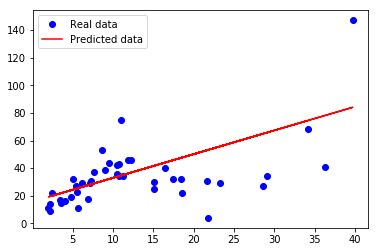

In [65]:
# plot the results
X, Y = data.T[0], data.T[1]
plt.plot(X, Y, 'bo', label='Real data')
plt.plot(X, X * w + b, 'r', label='Predicted data')
plt.legend()
plt.show()

